# Select dispatching rules using random forest

This notebook presents an implementation of a random forest for dynamically selecting dispatching rules based on the system state.

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import time
import sys
import pandas as pd
import shap
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from joblib import dump, load
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from time import mktime

tqdm.pandas()

sys.path.append("..")
from src.models import train_pipeline_model, evaluate_pipeline,  optimize_hyperparameters, plot_learning_curve
from src.utils import get_hyperparameter_number
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt, \
    assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, run_simulation_complete

## Get required data

In [2]:
# Load the training data
with open(r"../data/processed/data_processed_classification_training.pickle", "rb") as output_file:
    data_train = pickle.load(output_file)

In [3]:
# Load the validation data
with open(r"../data/processed/data_processed_classification_validation.pickle", "rb") as output_file:
    data_validation = pickle.load(output_file)

In [4]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [5]:
# Define constants for model training
RANDOM_STATE = 42
numeric_features = list(data_train.columns)
numeric_features.remove("priority_rule_start")
numeric_features.remove("priority_rule_score")
categorical_features =  ["priority_rule_start"]

In [6]:
# Define constants for simulation
priority_rules = {"edd": assign_priority_edd,
                  "spt": assign_priority_spt,
                  "srpt": assign_priority_srpt,
                  "fifo": assign_priority_fifo,
                  "cr": assign_priority_cr,
                  "mdd": assign_priority_mdd,
                  "lpt": assign_priority_lpt,
                  "ds": assign_priority_ds}
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list =  [40, 50, 60, 70]
random_states = [100, 101, 102]

# Prepare data

In [7]:
# Define features and flag
X = data_train.drop("priority_rule_score",  axis = 1)
y = data_train[["priority_rule_score"]]
X_validate = data_validation.drop("priority_rule_score",  axis = 1)
y_validate = data_validation[["priority_rule_score"]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model training

## Baseline

In [9]:
# Simple dummy classifier based on the maximization of the prior probability
dummy = DummyClassifier(strategy="prior", random_state=42)
dummy_fit = dummy.fit(X_train, y_train)
print(f"Accuracy of the dummy classifier is: {round(dummy_fit.score(X_test, y_test), 4)}")

Accuracy of the dummy classifier is: 0.2418


In [10]:
# Simple logistic regression baseline without hyperparameter tuning and feature selection
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)
pipeline_lr = train_pipeline_model(lr, X_train, y_train, numeric_features, categorical_features)
evaluate_pipeline(pipeline_lr, X_test, y_test)

Start at 10:54:17
Duration: 12.360175132751465
Start at 10:54:29
Accuracy: 0.46142578125
F1: 0.43263465330364026
Precision: 0.44603803103803535
Recall: 0.42746990199377655
Duration: 0.2273111343383789


## Hyperparameter search

In [11]:
# Define set of hyperparameters
# Define parameter search space
params_rf = {'classifier__criterion': ["gini", "entropy", "log_loss"],
             'classifier__max_depth': [5, 10, 20],
             'classifier__max_features': ['sqrt', 1, 2, 5,  "log2", None],
             'classifier__min_samples_leaf': [2, 5, 10],
             'classifier__min_samples_split': [2, 5, 10],
             'classifier__n_estimators': [5, 50, 100, 200],
             }
print(f"Set of {get_hyperparameter_number(params_rf)} hyperparameters")

Set of 1944 hyperparameters


Based on the variables we executed a grid hyperparameter search using successful halving.

In [12]:
# Fit hyperparameter search
model = RandomForestClassifier(random_state = RANDOM_STATE)
feature_selector = None
# fitted_clf = optimize_hyperparameters(X_train, y_train, model, feature_selector,numeric_features, categorical_features, params_rf, RANDOM_STATE)
# print(fitted_clf.best_params_)
# pd.DataFrame(fitted_clf.cv_results_).to_csv("../data/processed/hyperparameter_search/results_hyperparameter_random_forest.csv", index = False)

In [13]:
# Load best performing hyperparameter
results_hyperparameter = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_random_forest.csv")

The resulting set of optimal hyperparameter were:
**Random Forest**
* criterion='gini'
* max_depth=20
* max_features=None
* min_samples_leaf=2
* min_samples_split=5
* n_estimators=200

## Train final model

Train model for evaluation based on the select hyperparameter. Training duration is 168.73 seconds.

In [14]:
# Train pipeline based on hyperparameter
# Duration ~ 7 minutes
final_model = RandomForestClassifier(criterion='gini', max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)

In [15]:
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_random_forest_training.joblib')

In [16]:
# Load trained model
pipeline_trained = load('../models/pipeline_dispatching_classification_random_forest_training.joblib')

## Model evaluation

In [17]:
# Evaluate pipeline on train
evaluate_pipeline(pipeline_trained, X_train, y_train)

Start at 10:54:30
Accuracy: 0.9762369791666666
F1: 0.9768043275252236
Precision: 0.9807864142033709
Recall: 0.9730979932984023
Duration: 3.3176472187042236


In [18]:
# Evaluate pipeline on test
evaluate_pipeline(pipeline_trained, X_test, y_test)

Start at 10:54:33
Accuracy: 0.5780707465277778
F1: 0.5592874722592591
Precision: 0.5658025336017158
Recall: 0.5553651410695235
Duration: 0.8216719627380371


We can already see that the model quality sinks significantly which shows overfitting of the model on the training dataset.

In [19]:
# Plot learning curve based on data samples and fitting time
# May take some seconds to calculate
# plot_learning_curve(
#        pipeline_trained,
#        "Evaluation training set Random Forest",
#        X,
#        y.values.ravel(),
#        axes=None,
#        ylim=None,
#        cv=None,
#        n_jobs=-1,
#        scoring="accuracy",
#        train_sizes=np.linspace(0.1, 1.0, 5))

There overfitting is clearly visible however it seems like more training data is decreasing the overfitting effect. Therefore, one could try to improve the model using more data.

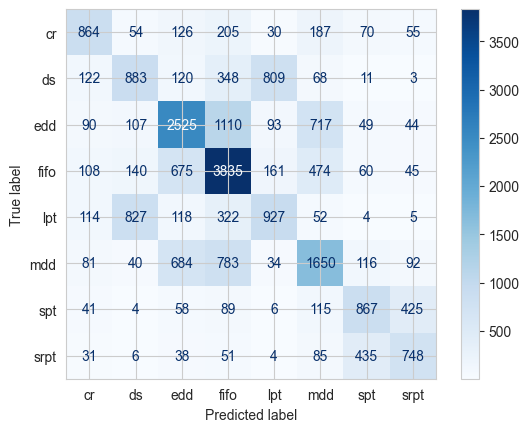

In [20]:
# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(
        pipeline_trained,
        X_validate,
        y_validate,
        cmap=plt.cm.Blues)

In [21]:
# Get feature names
# feature_names = pipeline_trained["preprocessor"].get_feature_names_out(X_validate.columns)

In [22]:
# Create explainer for the final model
explainer = shap.TreeExplainer(pipeline_trained["classifier"])
shap.initjs()

In [23]:
# Preprocess data to calculate shap values
# X_validate_processed = pipeline_trained["preprocessor"].transform(X_validate)
# shap_values = explainer.shap_values(X_validate_processed)

In [24]:
# Create a summary plot of the impact
# shap.summary_plot(shap_values, X_validate_processed, feature_names = feature_names)

In [25]:
# Calculate importance
# Duration ~ 90 minutes
# importance = permutation_importance(pipeline_trained, X_validate, y_validate,
#                            n_repeats=100,
#                            random_state=0)

In [26]:
# Visualize result
# fig, ax = plt.subplots()
# indices = importance['importances_mean'].argsort()[0:20]
# plt.barh(range(len(indices)),
#              importance['importances_mean'][indices],
#              xerr=importance['importances_std'][indices])
#
# ax.set_yticks(range(len(indices)))
# _ = ax.set_yticklabels(feature_names[indices])

## Train full model

Train the full model based on all available data. The training duration is around 137.45 seconds.

In [27]:
# Create combined dataset for training the final model
X_complete = pd.concat([X, X_validate])
y_complete = pd.concat([y, y_validate])

In [28]:
# Train pipeline based on hyperparameter
# Duration ~ 8 minutes
final_model = RandomForestClassifier(criterion='gini', max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200)
final_feature_selector = None
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_random_forest_complete.joblib')

In [29]:
# Load trained model
pipeline_simulation = load('../models/pipeline_dispatching_classification_random_forest_complete.joblib')

# Evaluation in simulation environment

In this section we define a simulation testing environment for testing and comparing the performance of different approaches. For this we create use repeated simulation of a factory with varying experiment settings. The trained algorithm are then used in the process to select dispatching rules.

In [30]:
# Execute simulation
# Duration ~ 10 minutes
# simulation_results = run_simulation_complete(pipeline_simulation, priority_rules, random_states, due_date_range_list,
#                                             number_orders_start_list,
#                                             average_count_new_orders_list, worker_list, "Random Forest Classification",
#                                             product_types_df, machines_df, orders_df, SIMULATION_START)

In [31]:
# Save simulation results
# simulation_results.to_csv("../data/processed/evaluation/simulation_results_validation_classification_random_forest.csv", index = False)

In [32]:
# Load simulation results
simulation_results = pd.read_csv("../data/processed/evaluation/simulation_results_validation_classification_random_forest.csv")

In [33]:
# Analyse simulation results profit
simulation_results["profit"] = simulation_results["revenue"] - simulation_results["penalty"]
print(f"Average profit is: {simulation_results.profit.mean()}")

Average profit is: 7675.783899458681


<AxesSubplot: xlabel='day', ylabel='profit'>

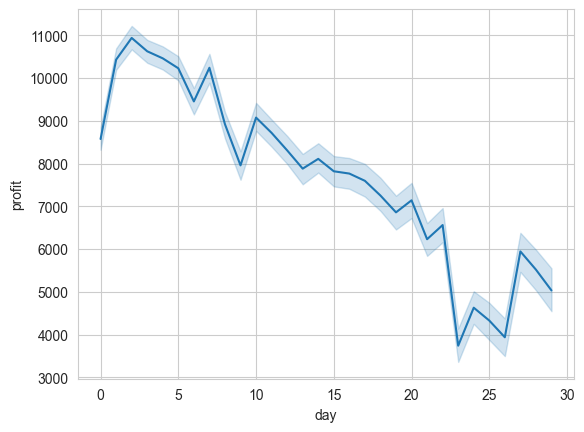

In [34]:
# Visualize profit
sns.lineplot(simulation_results, x = "day", y = "profit")

<AxesSubplot: xlabel='day', ylabel='profit'>

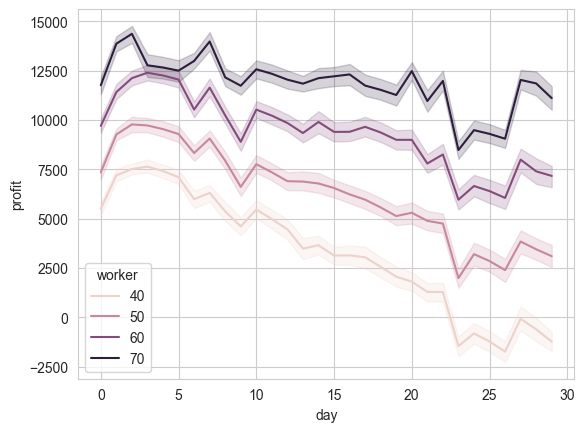

In [35]:
# Visualize profit per worker constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "worker")

<AxesSubplot: xlabel='day', ylabel='profit'>

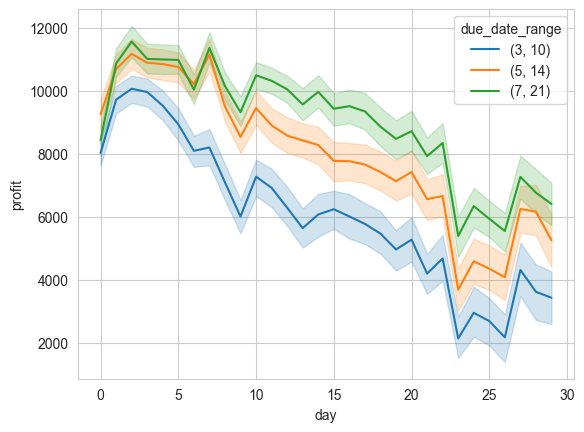

In [36]:
# Visualize profit per due date constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "due_date_range")

<AxesSubplot: xlabel='day', ylabel='profit'>

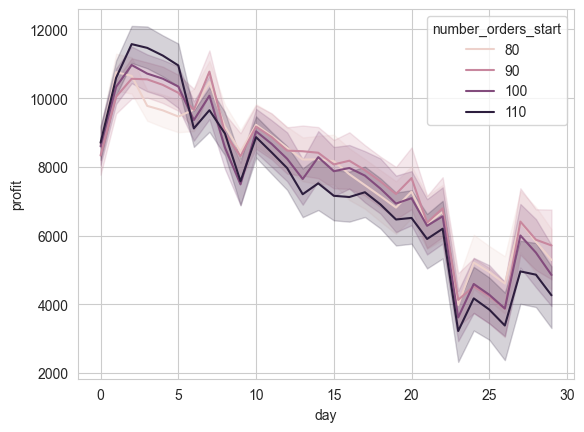

In [37]:
# Visualize profit per number_orders_start constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "number_orders_start")

<AxesSubplot: xlabel='day', ylabel='profit'>

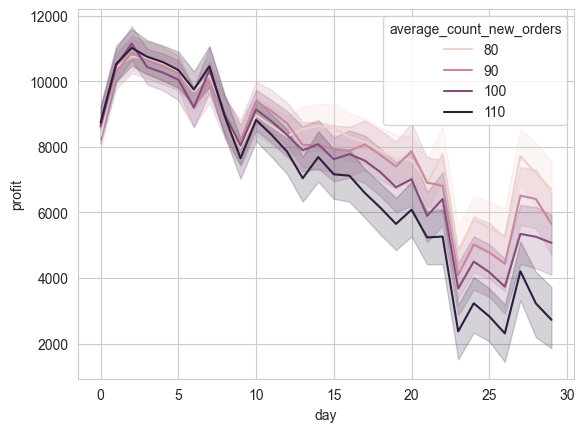

In [38]:
# Visualize profit per average count new orders constellation
sns.lineplot(simulation_results, x = "day", y = "profit", hue = "average_count_new_orders")